In [5]:
%matplotlib inline

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import statistics
from datetime import datetime
import scipy.stats as stats
from bokeh.io import output_notebook
output_notebook()
from bokeh.transform import linear_cmap
from bokeh.palettes import Plasma256 as palette
from bokeh.models import ColorBar
from bokeh.models import ColumnDataSource
import matplotlib.dates as mdates
from config import gmaps_api_key
from bokeh.io import show
from bokeh.plotting import gmap
from bokeh.models import GMapOptions

Loading BokehJS ...

In [4]:
crime_data = pd.read_csv('Crime_Data_from_2020_to_present.csv')

In [6]:
#format time properly
times = []
for time in crime_data['TIME OCC']:
    time_str = str(time)
    if len(time_str) == 1:
        converted_time = f"00:0{time_str[-1]}:00"
    elif len(time_str) == 2:
        converted_time = f"00:{time_str[-2:]}:00"
    elif len(time_str) == 3:
        converted_time = f"0{time_str[-3]}:{time_str[-2:]}:00"
    else:
        converted_time = f"{time_str[-4:-2]}:{time_str[-2:]}:00"
    times.append(converted_time)
crime_data['dt'] = pd.to_datetime(pd.to_datetime(crime_data['DATE OCC']).astype(str) + ' ' + times)

In [7]:
#remove unneeded rows
crime_df = crime_data.drop(['DR_NO','Date Rptd','Crm Cd','Crm Cd 1','Crm Cd 2', 'Crm Cd 3', 'Crm Cd 4','Part 1-2','Mocodes','Premis Cd', 
        'Premis Desc','Weapon Used Cd', 'Weapon Desc','Cross Street','Status', 'Status Desc','Rpt Dist No','DATE OCC'], axis=1,)
crime_df

,TIME OCC,AREA,AREA NAME,Crm Cd Desc,Vict Age,Vict Sex,Vict Descent,LOCATION,LAT,LON,dt
0,2230,3,Southwest,BATTERY - SIMPLE ASSAULT,36,F,B,1100 W 39TH PL,34.0141,-118.2978,2020-01-08 22:30:00
1,330,1,Central,BATTERY - SIMPLE ASSAULT,25,M,H,700 S HILL ST,34.0459,-118.2545,2020-01-01 03:30:00
2,1200,1,Central,SEX OFFENDER REGISTRANT OUT OF COMPLIANCE,0,X,X,200 E 6TH ST,34.0448,-118.2474,2020-02-13 12:00:00
3,1730,15,N Hollywood,VANDALISM - MISDEAMEANOR ($399 OR UNDER),76,F,W,5400 CORTEEN PL,34.1685,-118.4019,2020-01-01 17:30:00
4,415,19,Mission,"VANDALISM - FELONY ($400 & OVER, ALL CHURCH VA...",31,X,X,14400 TITUS ST,34.2198,-118.4468,2020-01-01 04:15:00
...,...,...,...,...,...,...,...,...,...,...,...
761577,1800,16,Foothill,"VANDALISM - FELONY ($400 & OVER, ALL CHURCH VA...",23,M,H,12500 BRANFORD ST,34.2466,-118.4054,2023-01-26 18:00:00
761578,1000,16,Foothill,"ASSAULT WITH DEADLY WEAPON, AGGRAVATED ASSAULT",25,F,H,12800 FILMORE ST,34.2790,-118.4116,2023-03-22 10:00:00
761579,1630,12,77th Street,"ASSAULT WITH DEADLY WEAPON, AGGRAVATED ASSAULT",29,M,B,6100 S VERMONT AV,33.9841,-118.2915,2023-04-12 16:30:00
761580,1,1,Central,PICKPOCKET,24,F,H,500 S MAIN ST,34.0467,-118.2485,2023-07-01 00:01:00


In [8]:
#classify crime types
violent = ['BATTERY - SIMPLE ASSAULT','RAPE, FORCIBLE', 
           'ASSAULT WITH DEADLY WEAPON, AGGRAVATED ASSAULT',
           'INTIMATE PARTNER - SIMPLE ASSAULT',
           'INTIMATE PARTNER - AGGRAVATED ASSAULT','BATTERY WITH SEXUAL CONTACT',
           'BATTERY POLICE (SIMPLE)','OTHER ASSAULT',
           'SEXUAL PENETRATION W/FOREIGN OBJECT','SHOTS FIRED AT INHABITED DWELLING',
           'ORAL COPULATION','ATTEMPTED ROBBERY','ROBBERY','BRANDISH WEAPON',
           'CHILD STEALING','KIDNAPPING - GRAND ATTEMPT','KIDNAPPING',
           'SEX,UNLAWFUL(INC MUTUAL CONSENT, PENETRATION W/ FRGN OBJ',
           'SODOMY/SEXUAL CONTACT B/W PENIS OF ONE PERS TO ANUS OTH',
           'CHILD ABUSE (PHYSICAL) - SIMPLE ASSAULT','RAPE, ATTEMPTED',
           'SHOTS FIRED AT MOVING VEHICLE, TRAIN OR AIRCRAFT','CRIMINAL HOMICIDE',
           'ASSAULT WITH DEADLY WEAPON ON POLICE OFFICER',
           'HUMAN TRAFFICKING - COMMERCIAL SEX ACTS','BATTERY ON A FIREFIGHTER',
           'CHILD ABUSE (PHYSICAL) - AGGRAVATED ASSAULT',
           'HUMAN TRAFFICKING - INVOLUNTARY SERVITUDE','LYNCHING - ATTEMPTED',
           'MANSLAUGHTER, NEGLIGENT','WEAPONS POSSESSION/BOMBING','LYNCHING',
           'BEASTIALITY, CRIME AGAINST NATURE SEXUAL ASSLT WITH ANIM',
           'CRIMINAL THREATS - NO WEAPON DISPLAYED','THREATENING PHONE CALLS/LETTERS']
property = ['VANDALISM - MISDEAMEANOR ($399 OR UNDER)',
            'VANDALISM - FELONY ($400 & OVER, ALL CHURCH VANDALISMS)',
            'SHOPLIFTING - PETTY THEFT ($950 & UNDER)',
            'THEFT-GRAND ($950.01 & OVER)EXCPT,GUNS,FOWL,LIVESTK,PROD',
            'ARSON','THEFT PLAIN - PETTY ($950 & UNDER)', 
            'THEFT OF IDENTITY','BURGLARY', 'VEHICLE - STOLEN',
            'THEFT FROM MOTOR VEHICLE - PETTY ($950 & UNDER)','BUNCO, GRAND THEFT', 
            'THEFT, PERSON','BIKE - STOLEN','BURGLARY FROM VEHICLE',
            'THEFT FROM MOTOR VEHICLE - GRAND ($950.01 AND OVER)',
            'THEFT FROM MOTOR VEHICLE - ATTEMPT','THROWING OBJECT AT MOVING VEHICLE',
            'EXTORTION','BURGLARY, ATTEMPTED',
            'EMBEZZLEMENT, GRAND THEFT ($950.01 & OVER)',
            'SHOPLIFTING-GRAND THEFT ($950.01 & OVER)','PURSE SNATCHING',
            'THEFT PLAIN - ATTEMPT','SHOPLIFTING - ATTEMPT',
            'THEFT FROM PERSON - ATTEMPT','BURGLARY FROM VEHICLE, ATTEMPTED',
            'VEHICLE - ATTEMPT STOLEN','EMBEZZLEMENT, PETTY THEFT ($950 & UNDER)',
            'DEFRAUDING INNKEEPER/THEFT OF SERVICES, $950 & UNDER',
            'CREDIT CARDS, FRAUD USE ($950 & UNDER','PICKPOCKET',
            'DOCUMENT WORTHLESS ($200 & UNDER)',
            'DEFRAUDING INNKEEPER/THEFT OF SERVICES, OVER $950.01',
            'DISHONEST EMPLOYEE - GRAND THEFT','TILL TAP - PETTY ($950 & UNDER)',
            'TILL TAP - GRAND THEFT ($950.01 & OVER)',
            'DOCUMENT WORTHLESS ($200.01 & OVER)',
            'CREDIT CARDS, FRAUD USE ($950.01 & OVER)',
            'VEHICLE, STOLEN - OTHER (MOTORIZED SCOOTERS, BIKES, ETC)',
            'PETTY THEFT - AUTO REPAIR','PURSE SNATCHING - ATTEMPT',
            'BIKE - ATTEMPTED STOLEN','BOAT - STOLEN',
            'THEFT, COIN MACHINE - GRAND ($950.01 & OVER)',
            'GRAND THEFT / INSURANCE FRAUD', 'DISHONEST EMPLOYEE - PETTY THEFT',
            'THEFT, COIN MACHINE - ATTEMPT',
            'THEFT, COIN MACHINE - PETTY ($950 & UNDER)','GRAND THEFT / AUTO REPAIR',
            'PICKPOCKET, ATTEMPT','TELEPHONE PROPERTY - DAMAGE',
            'DISHONEST EMPLOYEE ATTEMPTED THEFT','TRESPASSING']
other = ['SEX OFFENDER REGISTRANT OUT OF COMPLIANCE','OTHER MISCELLANEOUS CRIME',
         'LETTERS, LEWD  -  TELEPHONE CALLS, LEWD','VIOLATION OF COURT ORDER', 
         'VIOLATION OF RESTRAINING ORDER', 'DISTURBING THE PEACE',
         'CRM AGNST CHLD (13 OR UNDER) (14-15 & SUSP 10 YRS OLDER)','BOMB SCARE',
         'DOCUMENT FORGERY / STOLEN FELONY', 'INDECENT EXPOSURE',
         'VIOLATION OF TEMPORARY RESTRAINING ORDER','RESISTING ARREST',
         'DISCHARGE FIREARMS/SHOTS FIRED', 
         'LEWD/LASCIVIOUS ACTS WITH CHILD', 'LEWD CONDUCT',
         'UNAUTHORIZED COMPUTER ACCESS','CHILD NEGLECT (SEE 300 W.I.C.)', 
         'CONTEMPT OF COURT','CHILD ANNOYING (17YRS & UNDER)', 'BUNCO, ATTEMPT',
         'PIMPING', 'STALKING','FALSE IMPRISONMENT','FAILURE TO YIELD','COUNTERFEIT',
         'PROWLER','CHILD PORNOGRAPHY','PEEPING TOM','FIREARMS RESTRAINING ORDER (FIREARMS RO)',
         'DRIVING WITHOUT OWNER CONSENT (DWOC)','CRUELTY TO ANIMALS','FALSE POLICE REPORT', 
         'PANDERING', 'ILLEGAL DUMPING','RECKLESS DRIVING','CONSPIRACY', 'CONTRIBUTING',
         'BRIBERY','DISRUPT SCHOOL','REPLICA FIREARMS(SALE,DISPLAY,MANUFACTURE OR DISTRIBUTE)',
         'DRUGS, TO A MINOR','DRUNK ROLL', 'CHILD ABANDONMENT','BIGAMY', 'FAILURE TO DISPERSE',
         'FIREARMS EMERGENCY PROTECTIVE ORDER (FIREARMS EPO)',
         'INCEST (SEXUAL ACTS BETWEEN BLOOD RELATIVES)',
         'BLOCKING DOOR INDUCTION CENTER', 'INCITING A RIOT']

In [9]:
#add crime type column
type = []
for index, row in crime_df.iterrows():
    if row['Crm Cd Desc'] in violent:
        type.append('violent')
    elif row['Crm Cd Desc'] in property:
        type.append('property')
    else:
        type.append('other')
crime_df['type'] = type

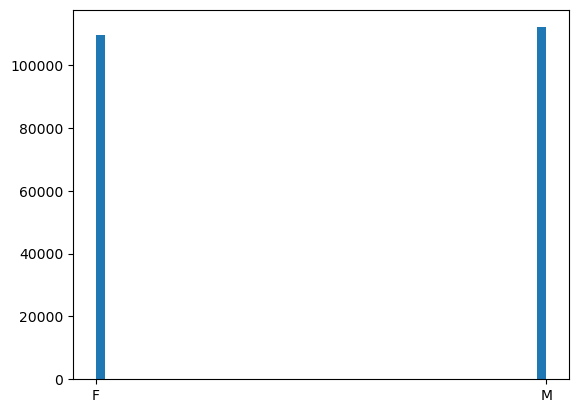

30

In [93]:
#analyze crime variation by age and sex
age_sex_df = crime_df[((crime_df['Vict Sex'] == 'M') | (crime_df['Vict Sex'] == 'F')) & (crime_df['Vict Age'] > 0)]
age_sex_df['Vict Descent'].value_counts()
as_type_df = age_sex_df[ (age_sex_df['type'] == 'violent')]#[age_sex_df['type'] == 'property']
#plt.hist(age_sex_df['Vict Age'],8)
plt.hist(as_type_df['Vict Sex'],49)
#plt.hist(age_sex_df['Vict Age'],98)
plt.show()
#men and women equal for violent, more men for property, significantly more women for other
statistics.mode(as_type_df['Vict Age'])

In [89]:
#calculate male to female and female to male ratios by crime description
f_desc = age_sex_df.loc[age_sex_df['Vict Sex'] == 'F','Crm Cd Desc'].value_counts()#[0:70]
m_desc = age_sex_df.loc[age_sex_df['Vict Sex'] == 'M','Crm Cd Desc'].value_counts()#[0:70]


findex_list = list(f_desc.index)
for type in f_desc.index:
    if type not in m_desc.index:
        findex_list.remove(type)    
fm_ratio = f_desc / m_desc[findex_list]

mindex_list = list(m_desc.index)
for type in m_desc.index:
    if type not in f_desc.index:
        mindex_list.remove(type)
mf_ratio = m_desc / f_desc[mindex_list]

In [104]:
mf_ratio.sort_values(ascending=False)[0:35]
m_desc[50:100]
age_sex_df['Crm Cd Desc'].value_counts()[0:20]
fm_ratio['BURGLARY FROM VEHICLE']


0.7515726911350392

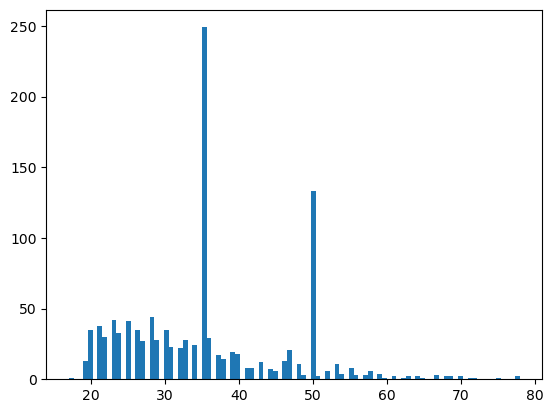

In [85]:
#Look at age by crime type of interest
#likely placeholder values for age (35,50)
plt.hist(age_sex_df.loc[age_sex_df['Crm Cd Desc'] == 'SHOPLIFTING-GRAND THEFT ($950.01 & OVER)','Vict Age'],95)
plt.show()

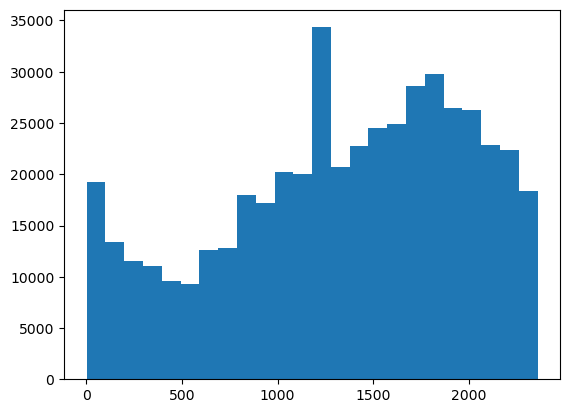

2359

In [77]:
#look at crimes by time of occurence
crime_type_df = crime_df[(crime_df['type'] == 'property')]# & (crime_df['TIME OCC'] != 1200)]
plt.hist(crime_type_df['TIME OCC'],24)
#plt.hist(crime_df['dt'].time())
plt.show()
#statistics.mode(crime_df['TIME OCC'])
#plt.hist(crime_df.loc[(crime_df['TIME OCC'] >= 1200) & (crime_df['TIME OCC'] < 1300),'TIME OCC'])
#peaks at between 5 and 7 for property, between 8 and 10 for violent, low for all types between 5 and 6 a.m.
#time of violent crimes would likely be more well known
crime_type_df.loc[crime_type_df['TIME OCC'] == 1200,'Crm Cd Desc'].value_counts()
max(crime_df['TIME OCC'])

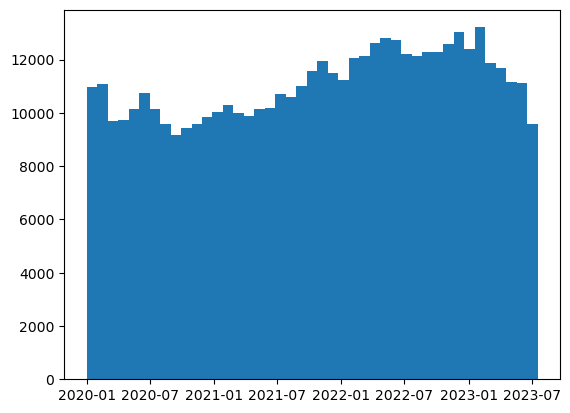

In [278]:
#look at crimes by date
crime_type_df = crime_df[(crime_df['type'] == 'property')]
plt.hist(crime_type_df['dt'],43)
plt.show()
#property crime levels off after 5th covid wave (omicron), worse than previously
#violent takes a dip around the holidays (dec, jan) and peaks in summer (july,august)
#other and violent not affected by covid


In [31]:
bins = [-1,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23]
time_labels = ['12 a.m.','1 a.m.','2 a.m.','3 a.m.','4 a.m.','5 a.m.','6 a.m.','7 a.m.','8 a.m.','9 a.m.','10 a.m.','11 a.m.','12 p.m.','1 p.m.','2 p.m.','3 p.m.','4 p.m.','5 p.m.','6 p.m.','7 p.m.','8 p.m.','9 p.m.','10 p.m.','11 p.m.']
standard_times = [crime_df['dt'][i].hour for i in range(len(crime_df))]
times = pd.cut(standard_times,bins,labels=time_labels,include_lowest=True)
crime_df['time'] = times

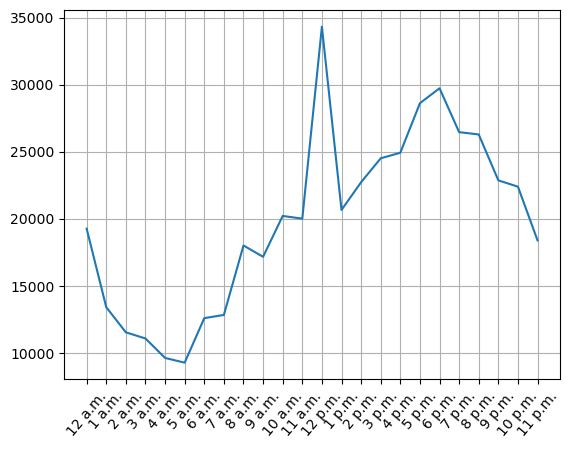

In [44]:
crime_type_df = crime_df[(crime_df['type'] == 'property')]
tvc = crime_type_df.groupby('time')['TIME OCC'].count()
plt.plot(tvc.index,tvc.values)
plt.xticks(rotation=50)
plt.grid()
plt.show()

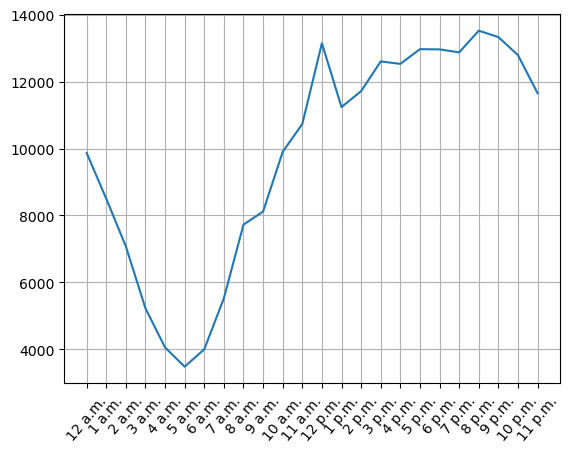

In [45]:
crime_type_df = crime_df[(crime_df['type'] == 'violent')]
tvc = crime_type_df.groupby('time')['TIME OCC'].count()
plt.plot(tvc.index,tvc.values)
plt.xticks(rotation=50)
plt.grid()
plt.show()

In [10]:
#Add column for month to crime_df
bins = [0,1,2,3,4,5,6,7,8,9,10,11,12]
month_number = [crime_df['dt'][i].month for i in range(len(crime_df))]
month_labels=['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
month = pd.cut(month_number, bins, labels=month_labels, include_lowest=True)
crime_df['month'] = month
#Add column for year
bins = [0,2020,2021,2022,2023]
year_labels=['2020','2021','2022','2023']
year_number = [crime_df['dt'][i].year for i in range(len(crime_df))]
year = pd.cut(year_number, bins, labels=year_labels, include_lowest=True)
crime_df['year'] = year

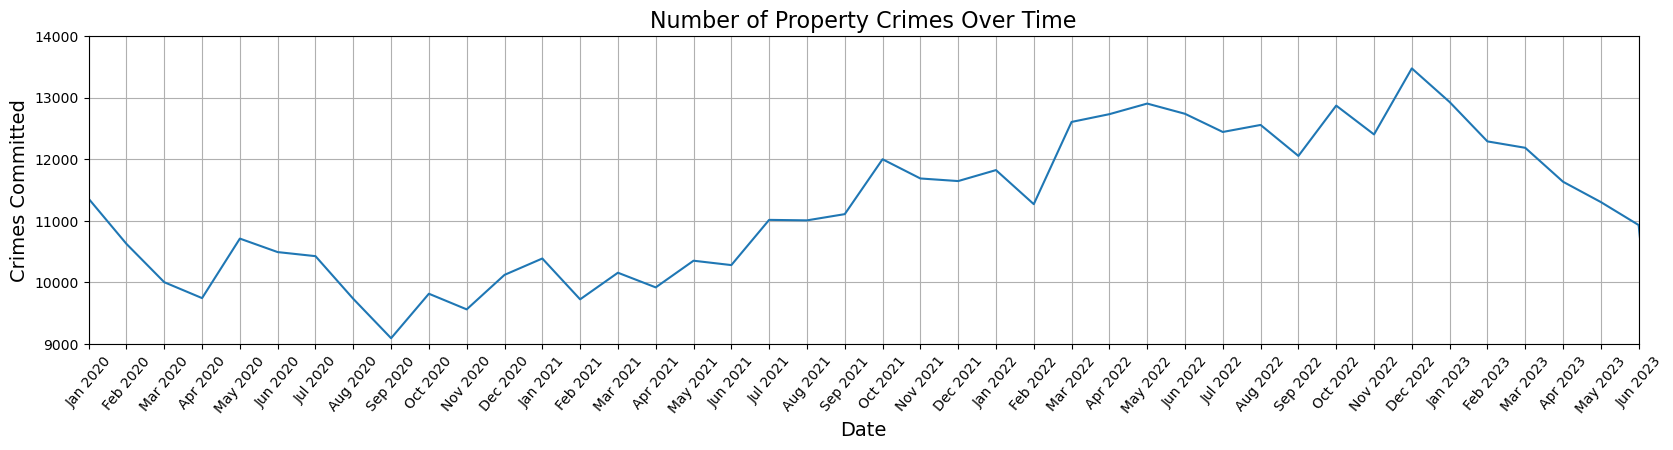

In [381]:
#create dataframe and plot for date(month and year) and number of property crimes
dates = []
crime_type_df = crime_df[(crime_df['type'] == 'property')]
date_counts = crime_type_df.groupby(['year','month'])['TIME OCC'].count()
for i in range(len(date_counts)):
    dates.append(f'{month_labels[i%12]} {year_labels[int(i/12)]}')
dvc = pd.DataFrame({'Date':dates,'Crimes':crime_type_df.groupby(['year','month'])['TIME OCC'].count().values})
dvc.plot(figsize=(20,4),grid=True,rot=50,legend=False)
plt.xticks(dvc.index,dvc['Date'])
plt.xlim((0,41))
plt.ylim((9000,14000))
plt.xlabel('Date',fontsize=14)
plt.ylabel('Crimes Committed',fontsize=14)
plt.title('Number of Property Crimes Over Time',fontsize=16)
plt.show()


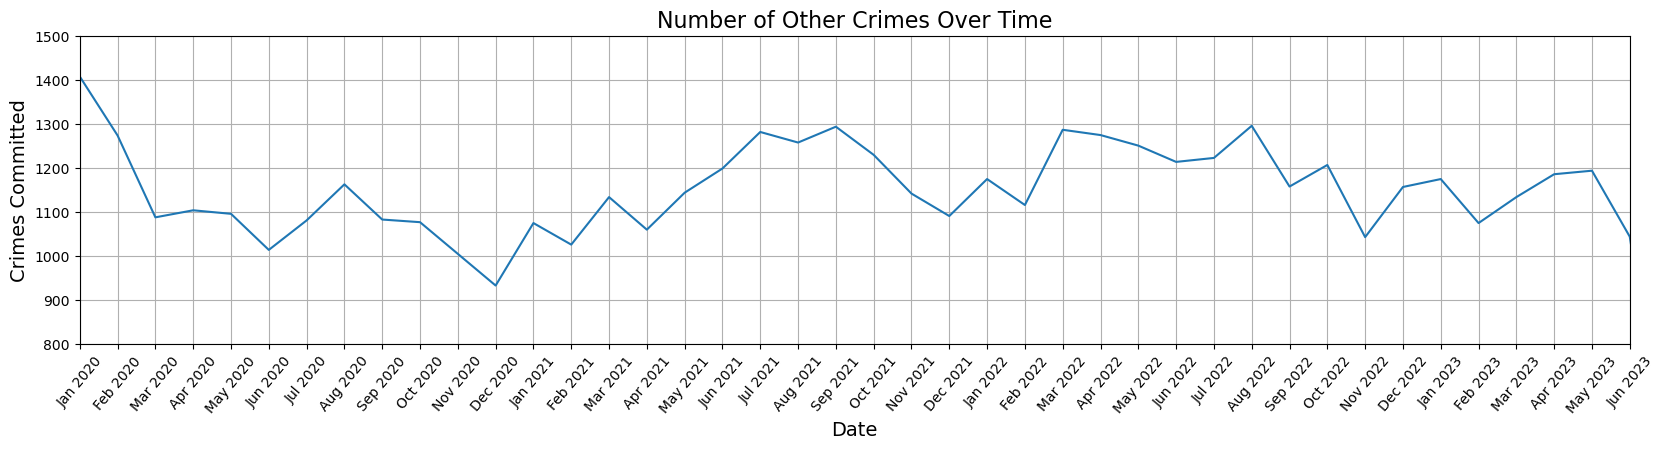

In [11]:
#create dataframe and plot for date(month and year) and number of other crimes
dates = []
crime_type_df = crime_df[(crime_df['type'] == 'other')]
date_counts = crime_type_df.groupby(['year','month'])['TIME OCC'].count()
for i in range(len(date_counts)):
    dates.append(f'{month_labels[i%12]} {year_labels[int(i/12)]}')
dvc = pd.DataFrame({'Date':dates,'Crimes':crime_type_df.groupby(['year','month'])['TIME OCC'].count().values})
dvc.plot(figsize=(20,4),grid=True,rot=50,legend=False)
plt.xticks(dvc.index,dvc['Date'])
plt.xlim((0,41))
plt.ylim((800,1500))
plt.xlabel('Date',fontsize=14)
plt.ylabel('Crimes Committed',fontsize=14)
plt.title('Number of Other Crimes Over Time',fontsize=16)
plt.show()


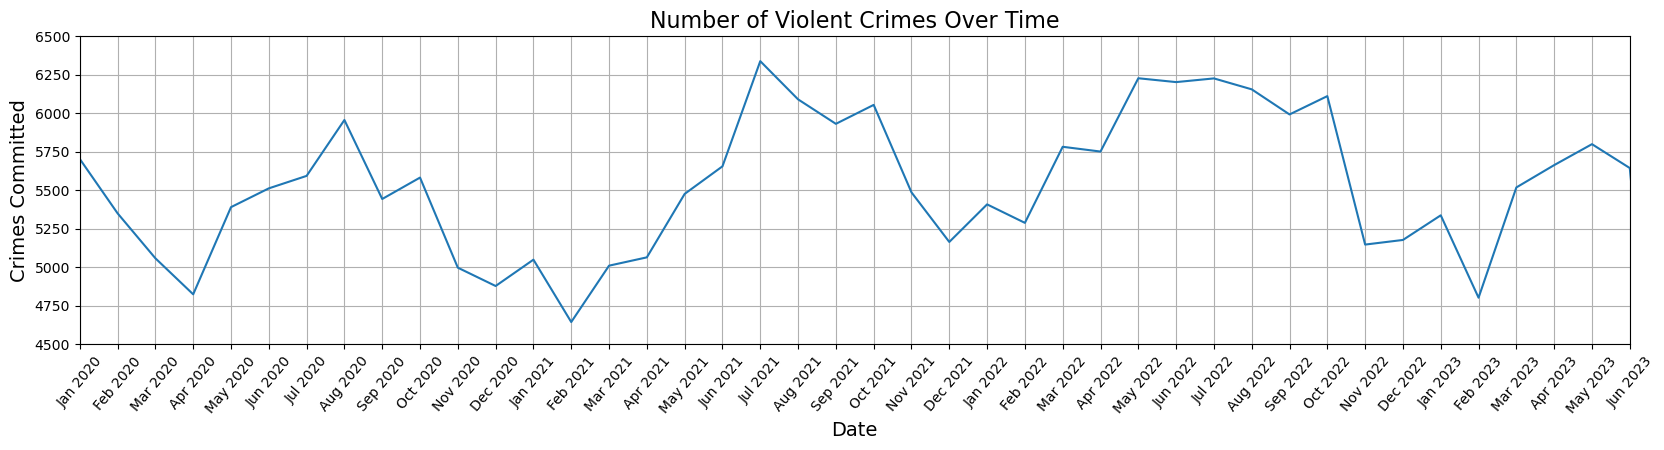

In [379]:
#create dataframe and plot for date(month and year) and number of violent crimes
dates = []
crime_type_df = crime_df[(crime_df['type'] == 'violent')]
date_counts = crime_type_df.groupby(['year','month'])['TIME OCC'].count()
for i in range(len(date_counts)):
    dates.append(f'{month_labels[i%12]} {year_labels[int(i/12)]}')
dvc = pd.DataFrame({'Date':dates,'Crimes':crime_type_df.groupby(['year','month'])['TIME OCC'].count().values})
dvc.plot(figsize=(20,4),grid=True,rot=50,legend=False)
plt.xticks(dvc.index,dvc['Date'])
plt.xlim((0,41))
plt.ylim((4500,6500))
plt.xlabel('Date',fontsize=14)
plt.ylabel('Crimes Committed',fontsize=14)
plt.title('Number of Violent Crimes Over Time',fontsize=16)
plt.show()

In [ ]:
weekday = [crime_df['dt'][i].weekday() for i in range(len(crime_df))]

In [56]:
#create DataFrame for chi squared test on day of week
day_counts = {}
day_counts['Monday'] = weekday.count(0)
day_counts['Tuesday'] = weekday.count(1)
day_counts['Wednesday'] = weekday.count(2)
day_counts['Thursday'] = weekday.count(3)
day_counts['Friday'] = weekday.count(4)
day_counts['Saturday'] = weekday.count(5)
day_counts['Sunday'] = weekday.count(6)
day_tester = pd.DataFrame.from_dict(day_counts,orient='index')
day_avg = len(crime_df)/7
day_tester['expected'] = day_avg
day_tester.rename(columns={0:'observed'},inplace=True)
day_tester
stats.chisquare(day_tester['observed'],day_tester['expected'])
plt.plot(day_tester.index,day_tester['observed'])
plt.grid()
plt.xticks(rotation=30)
plt.show()


Power_divergenceResult(statistic=822.63258322807, pvalue=1.9816994296171804e-174)

In [62]:
weekday_conversion = []
for i in range(len(weekday)):
    day_number = weekday[i]
    if day_number == 0:
        weekday_conversion.append('Monday')
    if day_number == 1:
        weekday_conversion.append('Tuesday')
    if day_number == 2:
        weekday_conversion.append('Wednesday')
    if day_number == 3:
        weekday_conversion.append('Thursday')
    if day_number == 4:
        weekday_conversion.append('Friday')
    if day_number == 5:
        weekday_conversion.append('Saturday')
    if day_number == 6:
        weekday_conversion.append('Sunday')

    
crime_df['weekday'] = weekday_conversion


weekday
Friday       33867
Monday       32931
Saturday     36547
Sunday       37478
Thursday     31682
Tuesday      31078
Wednesday    31989
Name: dt, dtype: int64

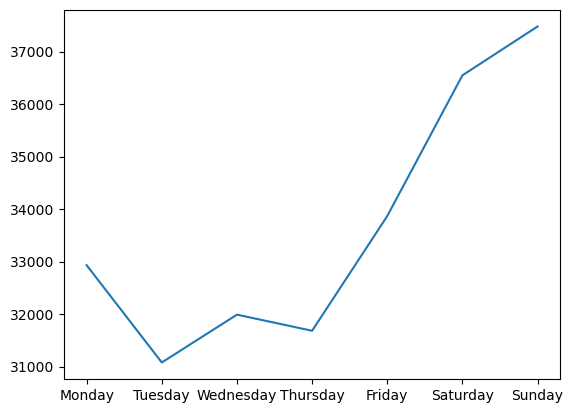

In [74]:
crime_type_df = crime_df[crime_df['type'] == 'violent']
wdvc = crime_type_df.groupby('weekday')['dt'].count()
wdvc2 = wdvc.reindex(['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'])
plt.plot(wdvc2.index,wdvc2.values)
plt.show()


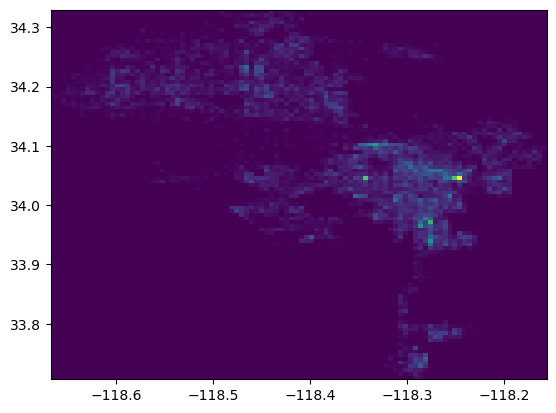

In [195]:
#crimes by location
crime_df_loc = crime_df[(crime_df['LAT'] != 0) & (crime_df['LON'] != 0)]
crime_df_type = crime_df_loc[crime_df_loc['type'] == 'other']
plt.hist2d(crime_df_type['LON'],crime_df_type['LAT'],bins=(100,100))
#plt.xlim(-118.4,-118.2)
#plt.ylim(33.9,34.15)
plt.show()
#violent crime more concentrated

In [265]:

bokeh_width, bokeh_height = 550,400
def plot(df,lat, lng, zoom=10, map_type='roadmap'):
    gmap_options = GMapOptions(lat=lat, lng=lng, 
                               map_type=map_type, zoom=zoom)
    tooltips = [('Area', '@area')]
    p = gmap(gmaps_api_key, gmap_options, title='Los Angeles', 
             width=bokeh_width, height=bokeh_height, 
             tools=['hover','reset', 'wheel_zoom', 'pan'],tooltips=tooltips)
    source = ColumnDataSource(df)
    # defining a color mapper, that will map values of pricem2
    # between 2000 and 8000 on the color palette
    mapper = linear_cmap(field_name='count', palette=palette, low = df['count'].min(),high = df['count'].max())    
    # we use the mapper for the color of the circles
    center = p.circle('lon','lat', size=10, alpha=1, color=mapper,source=source)
    #center = p.circle('lon', 'lat', size=4, alpha=0.2, 
    #                  color='yellow', source=source)
    # and we add a color scale to see which values the colors 
    color_bar = ColorBar(color_mapper=mapper['transform'], 
                         location=(0,0))
    p.add_layout(color_bar, 'right')
    show(p)
    return p

In [264]:
area_lat = crime_df_loc.groupby('AREA NAME')['LAT'].mean()
area_lon = crime_df_loc.groupby('AREA NAME')['LON'].mean()
area_count = crime_df_loc.groupby('AREA NAME')['AREA'].count()
loc_df = pd.DataFrame({'lat':area_lat,'lon':area_lon,'count':area_count,'area':area_count.index})
area_count.index

Index(['77th Street', 'Central', 'Devonshire', 'Foothill', 'Harbor',
       'Hollenbeck', 'Hollywood', 'Mission', 'N Hollywood', 'Newton',
       'Northeast', 'Olympic', 'Pacific', 'Rampart', 'Southeast', 'Southwest',
       'Topanga', 'Van Nuys', 'West LA', 'West Valley', 'Wilshire'],
      dtype='object', name='AREA NAME')

In [271]:
crime_df_loc['LAT'].max() - crime_df_loc['LAT'].min()
crime_df_loc['LON'].max() - crime_df_loc['LON'].min()
crime_df_loc['LON'].min()
#.63,.51; 33.7, -118.67

-118.6676

In [266]:
lat, lon = 34.1, -118.4
p = plot(loc_df,lat, lon)